In [1]:
import os
import psycopg2
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_palette("bright")
colors = sns.color_palette('bright')

%matplotlib inline

km_in_a_mile = 1.60934

conf_dir = os.path.join(os.environ['HOMEDRIVE'], os.environ['HOMEPATH'], r'Documents\config.txt')

def readConfig(key):
        config = pd.read_csv(conf_dir, header = None)
        config = [c.split('=') for c in config[0]]
        out = [c[1] for c in config if c[0] == key][0]
        return(out)

def dbGetQuery(q):
    pw = readConfig('pw')
    conn_string = "host='kavdb.c9lrodma91yx.us-west-2.rds.amazonaws.com' dbname='kavdb' user='lkavenagh' password='" + pw + "'"
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    dat = pd.read_sql(q, conn)
    conn.close()
    return(dat)

In [2]:
dat = dbGetQuery('SELECT date, \
                        exercise, \
                        weight, \
                        sets, \
                        reps, \
                        rep_unit, \
                        reps * sets as total_reps, \
                        avg(reps) over (partition by date, exercise) as avg_reps, \
                        sum(sets * reps) over (partition by date, exercise) as sets_x_reps, \
                        sum(weight * reps * sets) over (partition by date, exercise) / sum(reps * sets) over (partition by date, exercise) as w_avg_weight, \
                        sum(weight * reps * sets) over (partition by date, exercise) as training_vol \
                    FROM workouts.workouts ORDER BY date')
dat = dat.sort_values('date')

maxdate = max(dat.date)
eom_date = datetime.date(maxdate.year, maxdate.month+1, 1)
soy_date = datetime.date(maxdate.year, 1, 1)


C:\Users\lkave\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


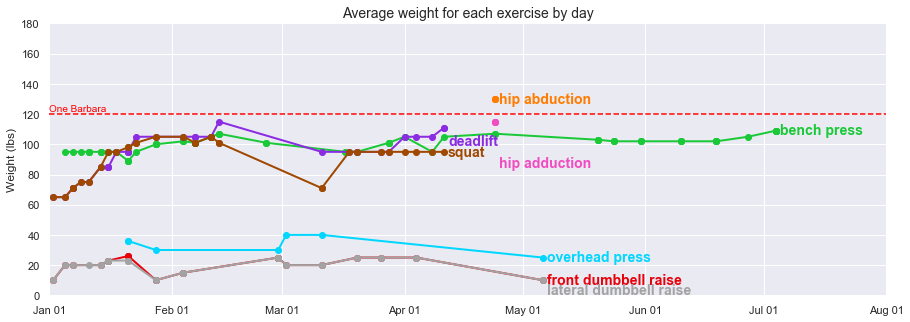

In [3]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

exercises = list(set(dat.exercise))

pos = []
for n,e in enumerate(exercises):
    this_dat = dat.loc[dat.exercise == e]
    if any(this_dat.rep_unit == 'rep'):
        ax.plot(this_dat.date, this_dat.w_avg_weight, label = e, linewidth = 2, marker='o', color = colors[n])
        this_pos = this_dat.w_avg_weight.tail(1).item()
        while any([abs(this_pos-c) / np.max(dat.w_avg_weight) < 0.05 for c in pos]):
            closest_val = min(pos, key=lambda x:abs(x-420))
            if this_pos >= closest_val:
                this_pos = this_pos + (np.max(dat.w_avg_weight)*0.01)
            else:
                this_pos = this_pos - (np.max(dat.w_avg_weight)*0.01)

        pos.append(this_pos)
        ax.text(max(this_dat.date)+datetime.timedelta(1), this_pos, e, color = colors[n], fontweight = 'bold', fontsize = 14, va = 'center')

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_ylabel('Weight (lbs)')
xfmt = mdates.DateFormatter('%b %d')
ax.xaxis.set_major_formatter(xfmt)
ax.set_title('Average weight for each exercise by day', fontsize = 14)
ax.set_ylim(0,180);
ax.set_xlim(soy_date, eom_date)

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [120, 120], color = 'red', linestyle = '--')
ax.text(x = ax.get_xlim()[0], y = 122, s = 'One Barbara', color = 'red');

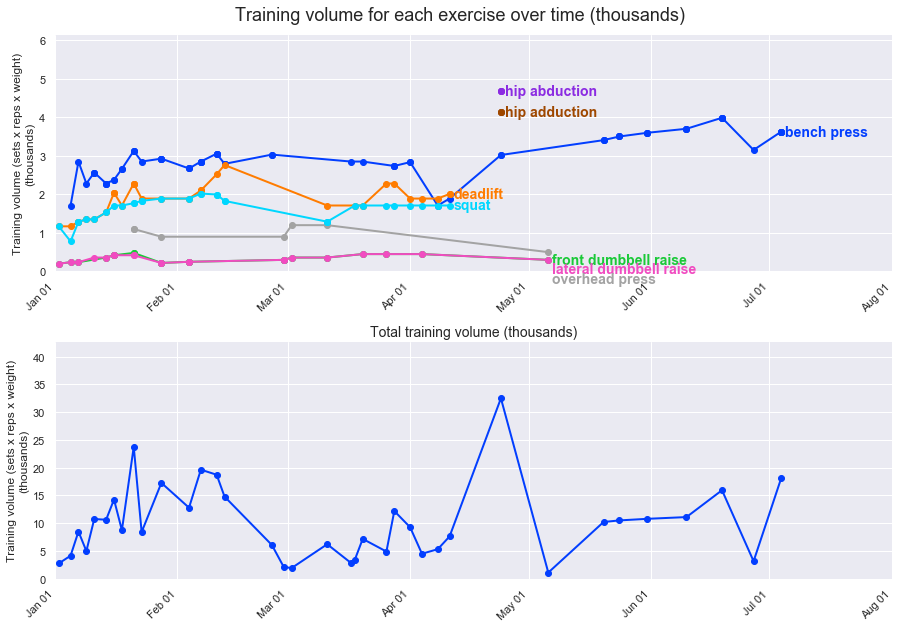

In [4]:
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace = 0.3)

axs = []
axs.append(fig.add_subplot(211))
axs.append(fig.add_subplot(212))

exercises = sorted(list(set(dat.exercise)))

pos = []
for n,e in enumerate(exercises):
    this_dat = dat.loc[dat.exercise == e]
    if any(this_dat.rep_unit == 'rep'):
        axs[0].plot(this_dat.date, this_dat.training_vol/1e3, label = e, linewidth = 2, marker='o', color = colors[n])
        this_pos = this_dat.training_vol.tail(1).item()/1e3
        while any([abs(this_pos-c) / np.max(dat.training_vol/1e3) < 0.05 for c in pos]):
            closest_val = min(pos, key=lambda x:abs(x-420))
            if this_pos >= closest_val:
                this_pos = this_pos + (np.max(dat.training_vol/1e3)*0.01)
            else:
                this_pos = this_pos - (np.max(dat.training_vol/1e3)*0.01)
        pos.append(this_pos)
        axs[0].text(max(this_dat.date)+datetime.timedelta(1), 
                    this_pos, 
                    e, 
                    color = colors[n], 
                    fontweight = 'bold', 
                    fontsize = 14,
                    va = 'center')

this_dat = dat.groupby('date', as_index = False).sum()[['date', 'training_vol']]
this_dat = this_dat.loc[this_dat.training_vol > 0]
axs[1].plot(this_dat.date, this_dat.training_vol/1e3, linewidth = 2, marker='o')

axs[1].set_title('Total training volume (thousands)', fontsize = 14)

xfmt = mdates.DateFormatter('%b %d')
for i in range(len(axs)):
    for var in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[var].set_visible(False)

    axs[i].set_ylabel('Training volume (sets x reps x weight)\n(thousands)')
    axs[i].xaxis.set_major_formatter(xfmt);
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    axs[i].set_xlim(soy_date, eom_date);
    axs[i].set_ylim(0,axs[i].get_ylim()[1]*1.25);

fig.suptitle('Training volume for each exercise over time (thousands)', fontsize = 18, y = 0.92);

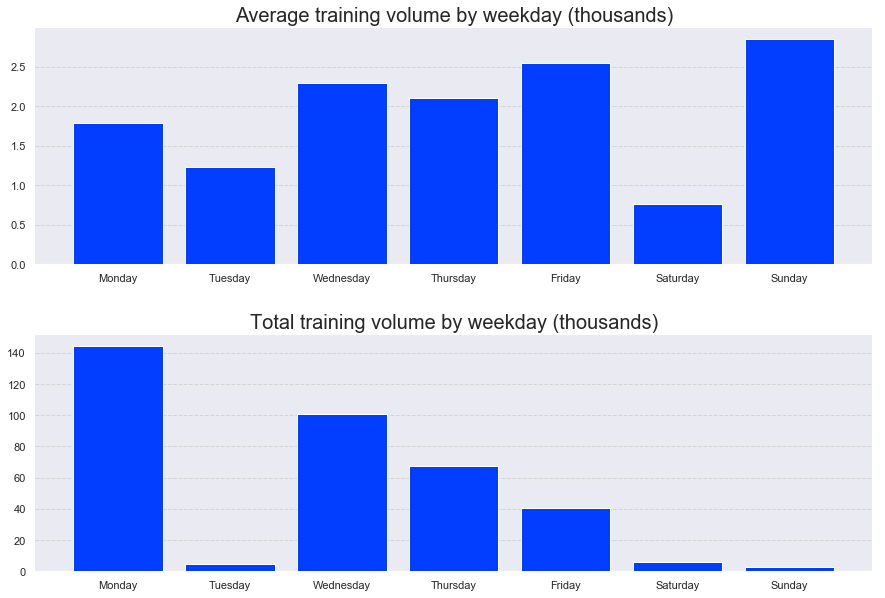

In [5]:
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace = 0.3)

axs = []
axs.append(fig.add_subplot(211))
axs.append(fig.add_subplot(212))

this_dat = dat.copy()
this_dat['dow'] = [c.weekday() for c in this_dat.date]
this_dat = this_dat.loc[this_dat.training_vol > 0]

this_dat_avg = this_dat.groupby('dow', as_index = False).mean()
this_dat_sum = this_dat.groupby('dow', as_index = False).sum()

axs[0].bar(this_dat_avg.dow, this_dat_avg.training_vol/1e3, zorder = 3)
axs[1].bar(this_dat_sum.dow, this_dat_sum.training_vol/1e3, zorder = 3)

axs[0].set_title('Average training volume by weekday (thousands)', fontsize = 20)
axs[1].set_title('Total training volume by weekday (thousands)', fontsize = 20)
for i in range(len(axs)):
    axs[i].set_xticks([0,1,2,3,4,5,6])

    for var in ['top', 'left', 'right']:
        axs[i].spines[var].set_visible(False)
    
axs[0].grid(linestyle = '--', color = 'lightgrey')
axs[1].grid(linestyle = '--', color = 'lightgrey')
axs[0].xaxis.grid(False)
axs[1].xaxis.grid(False)

axs[0].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
axs[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

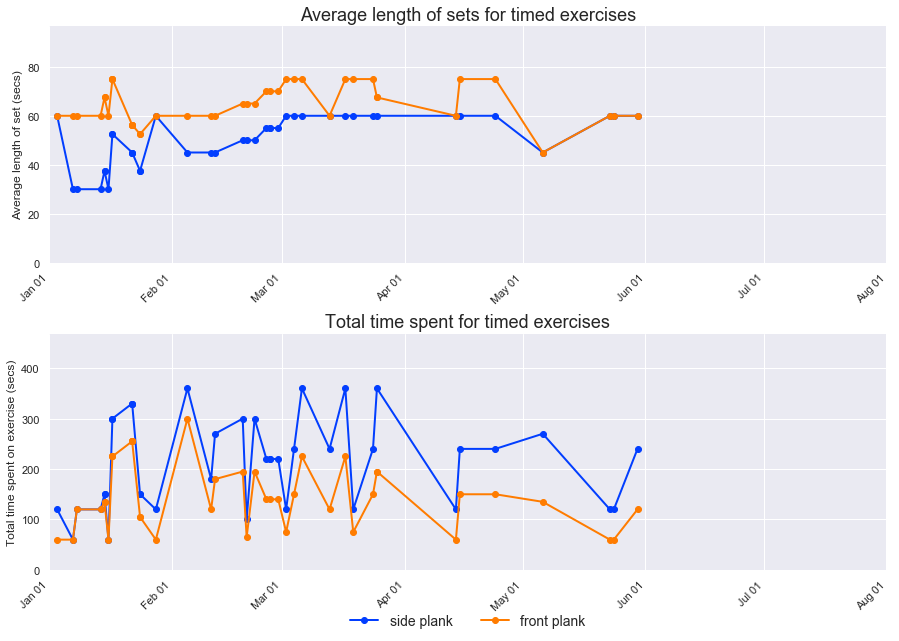

In [6]:
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace = 0.3)

axs = []
axs.append(fig.add_subplot(211))
axs.append(fig.add_subplot(212))

exercises = list(set(dat.exercise))

for n,e in enumerate(exercises):
    this_dat = dat.loc[dat.exercise == e]
    if any(this_dat.rep_unit == 'sec'):
        axs[0].plot(this_dat.date, this_dat.avg_reps, label = e, linewidth = 2, marker='o')
        axs[1].plot(this_dat.date, this_dat.sets_x_reps, label = e, linewidth = 2, marker='o')

xfmt = mdates.DateFormatter('%b %d')
for i in range(len(axs)):
    for var in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[var].set_visible(False)

    for tick in axs[i].get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    axs[i].xaxis.set_major_formatter(xfmt)
    axs[i].set_xlim(soy_date, eom_date);
    axs[i].set_ylim(0, axs[i].get_ylim()[1]*1.25);

axs[1].legend(frameon = False, fontsize = 14, loc = 'lower center', bbox_to_anchor=(0.5, -0.3), ncol = 5)

axs[0].set_ylabel('Average length of set (secs)')
axs[0].set_title('Average length of sets for timed exercises', fontsize = 18)

axs[1].set_ylabel('Total time spent on exercise (secs)')
axs[1].set_title('Total time spent for timed exercises', fontsize = 18);